In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from common import geo_to_cartesian_m, calculate_centroids, cartesian_to_geo, haversine_np

In [2]:
df = pd.read_csv("data/mappers_processed.csv")

In [3]:
# Limit to SF Bay
lat_bounds = [37, 38]
long_bounds = [-124, -122]

df = df[df["target_lat"] > min(lat_bounds)]
df = df[df["target_lat"] < max(lat_bounds)]
df = df[df["target_long"] > min(long_bounds)]
df = df[df["target_long"] < max(long_bounds)]

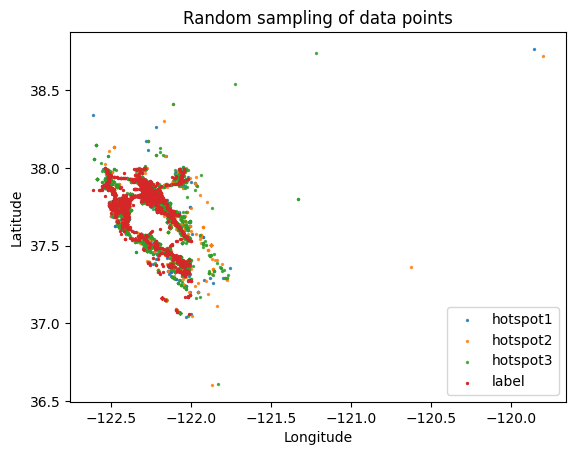

In [4]:
subset = df.sample(n=min(len(df), 5000))
for i in range(1,4):
    plt.scatter(subset[f"hotspot{i}_long"], subset[f"hotspot{i}_lat"], s=2, alpha=0.8, label=f"hotspot{i}")
plt.scatter(subset["target_long"], subset["target_lat"], s=2, label="label")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random sampling of data points")
plt.legend()

In [5]:
# Limit the number of samples
max_samples = 10000
if df.shape[0] > max_samples:
    print(f"Limiting # samples from {df.shape[0]} to {max_samples}")
    df = df.sample(n=max_samples)

Limiting # samples from 413023 to 10000


In [6]:
data = np.concatenate([
    df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy() for prefix in ["target", "hotspot1", "hotspot2", "hotspot3"]
])
print(data.shape)

(40000, 2)


In [7]:
def k_means(data, k:int=50, num_iter:int=50, seed:int=42, trace: bool=False):
    np.random.seed(seed)

    n, d = data.shape
    # Pre-compute cartesian coordinates for each data point
    data_xyz_m = geo_to_cartesian_m(
        lat_long_alt=np.stack([data[:,0], data[:,1], np.zeros((n))], axis=1)
    )
    # Initialize centroids as random selection of data points
    centroids = data[np.random.choice(n, k, replace=False)] # k, d 
    diff = np.zeros((n,k))

    for _ in tqdm(range(num_iter), disable=not trace):
        # Assign centroids based on minimum haversine distance
        for i in range(k):
            diff[:, i] = haversine_np(data, centroids[np.newaxis, i,:])
        labels = diff.argmin(axis=1) # n,

        # Update the centroids to be the projected centroid of the members of each cluster
        for i in range(k):
            members_xyz_m = data_xyz_m[np.argwhere(labels==i), :]
            if members_xyz_m.shape[0] == 0:
                # empty cluster... don't update
                continue
            centroid_xyz_m = calculate_centroids(coordinates_xyz_m=members_xyz_m[:, :], project=True)
            centroid_lat_long = cartesian_to_geo(xyz_m=centroid_xyz_m)[:,:2]
            centroids[i] = centroid_lat_long
        
    return centroids

In [8]:
# Cluster
centroids = k_means(data, k=2000, trace=True)

100%|██████████| 50/50 [03:10<00:00,  3.82s/it]


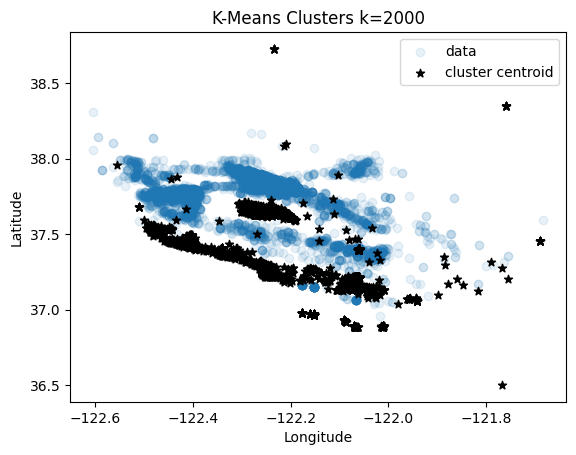

In [9]:
# Visualize clusters
subset = data[np.random.choice(data.shape[0], min(10000, data.shape[0]), replace=False), :]
plt.scatter(subset[:,1], subset[:,0], alpha=0.1, label="data")
plt.scatter(centroids[:,1], centroids[:,0], marker="*", color="k", label="cluster centroid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title(f"K-Means Clusters k={centroids.shape[0]}")
plt.show()